# Training an MLP using UKF/EKF

In [2]:
import jax
import flax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from flax import linen as nn
from jax.random import PRNGKey, normal, split
from jax.ops import index_update
from tqdm.notebook import tqdm
from functools import partial

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

$$
    y=x + 2\cos(x)(-5)\sin(x) + x^3
$$

In [4]:
def f(x): return x -10 * jnp.cos(x) * jnp.sin(x) + x ** 3

In [884]:
n_obs = 100
key = PRNGKey(314)
key_x, key_y = split(key, 2)
noise_y = normal(key, (n_obs, ))

In [885]:
x.shape

(100,)

In [956]:
x = jnp.linspace(-jnp.pi, jnp.pi, n_obs)
key = PRNGKey(31415)
x = normal(key, (n_obs,))
y = f(x) + noise_y * 3

X = np.c_[x, y]
np.random.shuffle(X)
x, y = X.T

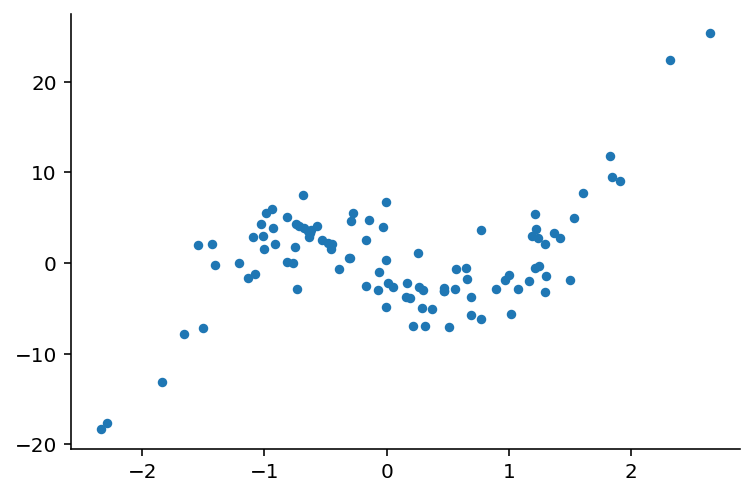

In [957]:
plt.scatter(x, y, s=14)

## MLP

In [1001]:
class MLP1D(nn.Module):
    n_hidden: int
        
    def setup(self):
        self.layer1 = nn.Dense(self.n_hidden)
        self.layer2 = nn.Dense(self.n_hidden)
        self.layer_out = nn.Dense(1)
    
    def __call__(self, x):
        x = x[:, None]
        x = nn.sigmoid(self.layer1(x))
        x = nn.sigmoid(self.layer2(x))
        x = self.layer_out(x)
        return x

In [1002]:
def make_mse(x_batch, y_batch):
    def mse(params):
        def squared_error(x, y):
            yhat = model.apply(params, x)
            err = y - yhat
            return jnp.inner(err, err) / 2.0
        return jnp.mean(jax.vmap(squared_error)(x_batch, y_batch), axis=0).ravel()[0]
    return jax.jit(mse)

loss = make_mse(x[:,None], y)

In [1003]:
key = PRNGKey(314)
key1, key2 = split(key, 2)

model = MLP1D(3)
params = model.init(key1, x) 
yhat = model.apply(params, x)

In [1004]:
yhat = model.apply(params, x)
err = (y[:, None] - yhat)
jnp.linalg.norm(err, 2) ** 2 / (2 * len(x))

DeviceArray(17.92406, dtype=float32)

In [1011]:
alpha = 0.1
n_epochs = 500
grad_fn = jax.value_and_grad(loss)
pb = tqdm(range(n_epochs))
for i in pb:
    loss_val, grads =  grad_fn(params)
    params = jax.tree_multimap(lambda p, g: p - alpha * g, params, grads)
    if i % 100 == 0:
        desc = f"Loss step {i:03}: {loss_val:0.2f}"
        pb.set_description_str(desc)

  0%|          | 0/500 [00:00<?, ?it/s]

In [1012]:
xtest = jnp.linspace(x.min(), x.max(), 200)
yhat_test = model.apply(params, xtest)

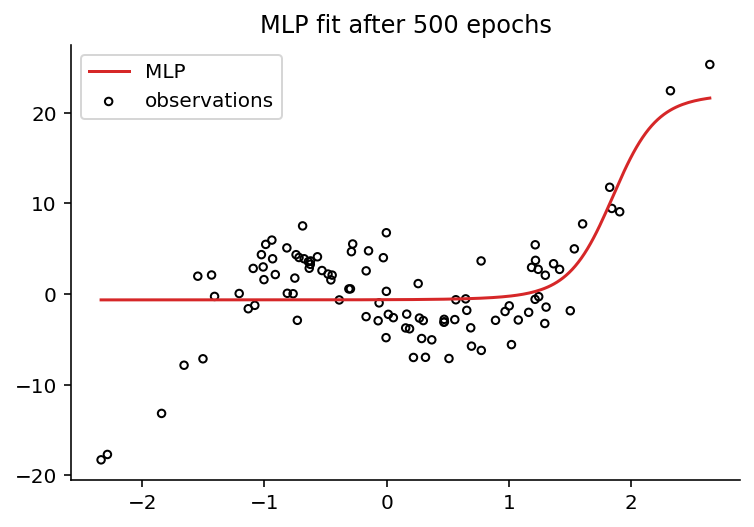

In [1013]:
plt.plot(xtest, yhat_test, c="tab:red", label="MLP")
# plt.plot(x, f(x), label="underlying", linestyle="--")
plt.scatter(x, y, s=14, c="none", edgecolor="black", label="observations")
plt.title(f"MLP fit after {n_epochs} epochs")
plt.legend()

In [1014]:
# This doesn't work
Hw = jax.jacobian(model)
Hw(x)

AttributeError: "MLP1D" object has no attribute "layer1"

# UKF Method

In [1015]:
W0 = jax.tree_map(lambda p: p * 0, params)

In [1016]:
jax.tree_map(lambda p: p.shape, params)

FrozenDict({
    params: {
        layer1: {
            bias: (3,),
            kernel: (1, 3),
        },
        layer2: {
            bias: (3,),
            kernel: (3, 3),
        },
        layer_out: {
            bias: (1,),
            kernel: (3, 1),
        },
    },
})

In [1017]:
def fz(W): return W
def fx(W, x): return model.apply(params, x)

In [1018]:
fx(params, x[0, None])

DeviceArray([[-0.57835]], dtype=float32)

In [1019]:
leafs, treedef = jax.tree_util.tree_flatten(params)

In [1020]:
jax.tree_unflatten(treedef, leafs)

FrozenDict({
    params: {
        layer1: {
            bias: DeviceArray([-5.13924,  4.32514, -3.79382], dtype=float32),
            kernel: DeviceArray([[ 2.38328, -2.35102,  2.58541]], dtype=float32),
        },
        layer2: {
            bias: DeviceArray([ 1.51487, -1.35662,  1.11615], dtype=float32),
            kernel: DeviceArray([[-4.14   ,  3.58649, -2.7352 ],
                         [ 3.90814, -3.79021,  3.2058 ],
                         [-2.23882,  2.95252, -2.998  ]], dtype=float32),
        },
        layer_out: {
            bias: DeviceArray([9.91317], dtype=float32),
            kernel: DeviceArray([[-6.30281],
                         [12.34965],
                         [-4.43121]], dtype=float32),
        },
    },
})

### Flatten and reconstruction of the weights

In [1021]:
leafs, treedef = jax.tree_util.tree_flatten(params)
shapes = [leaf.shape for leaf in leafs]

# Flattening of the parameters
all_params = jax.tree_map(lambda v: v.reshape(-1, 1), leafs)
all_params = jnp.concatenate(all_params)
all_params.shape 

(22, 1)

In [1022]:
# cut-off points of the flattened weigths
indices = jnp.array([np.prod(s) for s in shapes]).cumsum()

# Pytree (dict) reconstruction of the weights
split_reconstruction = jnp.array_split(all_params, indices)
split_reconstruction = [arr.reshape(shape) for arr, shape in zip(split_reconstruction, shapes)]
params_reconstructed = jax.tree_unflatten(treedef, split_reconstruction)

In [1023]:
def sqrtm(M):
    """
    Compute the matrix square-root of a hermitian
    matrix M. i,e, R such that RR = M

    Parameters
    ----------
    M: array(m, m)
        Hermitian matrix

    Returns
    -------
    array(m, m): square-root matrix
    """
    evals, evecs = jnp.linalg.eigh(M)
    R = evecs @ jnp.sqrt(jnp.diag(evals)) @ jnp.linalg.inv(evecs)
    return R

In [1024]:
n_params, _ = all_params.shape
Sigma0 = jnp.eye(n_params)
Sigma_half = sqrtm(Sigma0)
Sigma_half

DeviceArray([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0.],
             [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.

In [1025]:
model.apply(params_reconstructed, x[1, None])

DeviceArray([[-0.66321]], dtype=float32)

In [1026]:
shapes

[(3,), (1, 3), (3,), (3, 3), (1,), (3, 1)]

In [1027]:
treedef

PyTreeDef(CustomNode(<class 'flax.core.frozen_dict.FrozenDict'>[()], [{'params': {'layer1': {'bias': *, 'kernel': *}, 'layer2': {'bias': *, 'kernel': *}, 'layer_out': {'bias': *, 'kernel': *}}}]))

In [1028]:
def reconstruct_weights(params_flat, shapes, treedef):
    indices = jnp.array([np.prod(s) for s in shapes]).cumsum()
    split_reconstruction = jnp.array_split(params_flat, indices)
    split_reconstruction = [arr.reshape(shape) for arr, shape in zip(split_reconstruction, shapes)]
    params = jax.tree_unflatten(treedef, split_reconstruction)
    return params


def forward_mlp(X, params_flat, model, shapes, treedef):
    """
    Run the flax-MLP with flattened parameters
    
    Parameters
    ----------
    X: array(n_obs, dim_in)
        Array of observations
    params_flat: array(n_params, )
    model: Subclass of nn.module
    shapes: list of tuples
        Each element contains the original
        shape of the MLP
    treedef: PyTreeDef
        Result of running jax.tree_util.tree_flatten
        over `model`
    
    Returns
    -------
    * array(n_obs, dim_out?)
    """
    params = reconstruct_weights(params_flat, shapes, treedef)
    yhat = model.apply(params, X)
    return yhat

In [1029]:
forward_mlp(x[1, None],  all_params, model, shapes, treedef)

DeviceArray([[-0.66321]], dtype=float32)

In [1030]:
model.apply(params, x[1, None])

DeviceArray([[-0.66321]], dtype=float32)

In [1031]:
class UnscentedKalmanFilter:
    """
    Implementation of the Unscented Kalman Filter for discrete time systems
    """
    def __init__(self, fz, fx, Q, R, alpha, beta, kappa):
        self.fz = fz
        self.fx = fx
        self.Q = Q
        self.R = R
        self.d, _ = Q.shape
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa
        self.lmbda = alpha ** 2 * (self.d + kappa) - self.d
        self.gamma = jnp.sqrt(self.d + self.lmbda)
    
    @staticmethod
    def sqrtm(M):
        """
        Compute the matrix square-root of a hermitian
        matrix M. i,e, R such that RR = M
        
        Parameters
        ----------
        M: array(m, m)
            Hermitian matrix
        
        Returns
        -------
        array(m, m): square-root matrix
        """
        evals, evecs = jnp.linalg.eigh(M)
        R = evecs @ jnp.sqrt(jnp.diag(evals)) @ jnp.linalg.inv(evecs)
        return R

    def filter(self, init_state, sample_obs, X):
        """
        Run the Unscented Kalman Filter algorithm over a set of observed samples.
        Parameters
        ----------
        sample_obs: array(nsamples, obs_size)
        Returns
        -------
        * array(nsamples, state_size)
            History of filtered mean terms
        * array(nsamples, state_size, state_size)
            History of filtered covariance terms
        """
        wm_vec = jnp.array([1 / (2 * (self.d + self.lmbda)) if i > 0
                            else self.lmbda / (self.d + self.lmbda)
                            for i in range(2 * self.d + 1)])
        wc_vec = jnp.array([1 / (2 * (self.d + self.lmbda)) if i > 0
                            else self.lmbda / (self.d + self.lmbda) + (1 - self.alpha ** 2 + self.beta)
                            for i in range(2 * self.d + 1)])
        
        
        nsteps, _ = sample_obs.shape
        mu_t = init_state
        Sigma_t = self.Q

        mu_hist = jnp.zeros((nsteps, self.d))
        Sigma_hist = jnp.zeros((nsteps, self.d, self.d))

        mu_hist = index_update(mu_hist, 0, mu_t)
        Sigma_hist = index_update(Sigma_hist, 0, Sigma_t)
        
        for t in range(1, nsteps):
            # TO-DO: use jax.scipy.linalg.sqrtm when it gets added to lib
            comp1 = mu_t[:, None] + self.gamma * self.sqrtm(Sigma_t)
            comp2 = mu_t[:, None] - self.gamma * self.sqrtm(Sigma_t)
            #print('kpm')
            #print([mu_t.shape, comp1.shape, comp2.shape])
            #sigma_points = jnp.c_[mu_t, comp1, comp2]
            sigma_points = jnp.concatenate((mu_t[:, None], comp1, comp2), axis=1)

            z_bar = self.fz(sigma_points)
            mu_bar = z_bar @ wm_vec
            Sigma_bar = (z_bar - mu_bar[:, None])
            Sigma_bar = jnp.einsum("i,ji,ki->jk", wc_vec, Sigma_bar, Sigma_bar) + self.Q
            
            # Second step
            Sigma_bar_half = self.sqrtm(Sigma_bar)
            comp1 = mu_bar[:, None] + self.gamma * Sigma_bar_half
            comp2 = mu_bar[:, None] - self.gamma * Sigma_bar_half
            #sigma_points = jnp.c_[mu_bar, comp1, comp2]
            sigma_points = jnp.concatenate((mu_bar[:, None], comp1, comp2), axis=1)

            ## ****** Some important code here ******
            x_bar = self.fx(X[t, None], sigma_points).ravel()
            x_hat = x_bar @ wm_vec
            St = (x_bar - x_hat)
            # St = jnp.einsum("i,ji,ki->jk", wc_vec, St, St) + self.R
            St = (wc_vec * St ** 2).sum() + self.R

            mu_hat_component = (z_bar - mu_bar[:, None])
            x_hat_component = (x_bar - x_hat)[None, :]
            Sigma_bar_y = jnp.einsum("i,ji,ki->jk", wc_vec, mu_hat_component, x_hat_component)
            
        
            Kt = Sigma_bar_y @ jnp.linalg.inv(St)
            mu_t = mu_bar + Kt @ (sample_obs[t] - x_hat)
            Sigma_t = Sigma_bar - Kt @ St @ Kt.T
            
            mu_t = mu_t.ravel()
            mu_hist = index_update(mu_hist, t, mu_t)
            Sigma_hist = index_update(Sigma_hist, t, Sigma_t)

        return mu_hist, Sigma_hist

In [1032]:
# Check whether 'unrolled' forward is the same as flax's forward
fx_p = partial(forward_mlp, model=model, shapes=shapes, treedef=treedef)
assert fx_p(x[1, None], all_params)  == model.apply(params, x[1, None])

In [1072]:
n_params, _ = all_params.shape

key = PRNGKey(3141)
σ = 50
mu0 = normal(key, (n_params,)) * σ

In [1075]:
Q = jnp.eye(n_params) * σ ** 2
R = jnp.eye(1) * 1 ** 2
alpha, beta, kappa = 0.5, 0.1, 0.5

fx_p = partial(forward_mlp, model=model, shapes=shapes, treedef=treedef)
fx_vmap = jax.vmap(fx_p, in_axes=[None, 1])
ukf = UnscentedKalmanFilter(fz, fx_vmap, Q, R, alpha, beta, kappa)
mu_hist, Sigma_hist = ukf.filter(mu0, y[:, None], x)

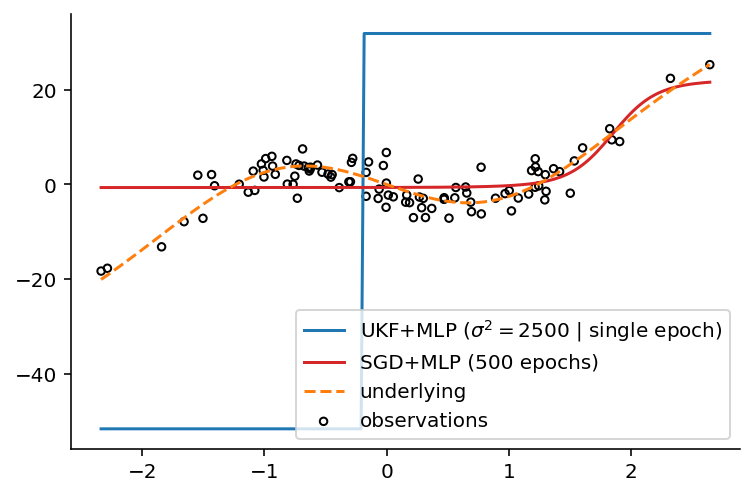

In [1076]:
plt.plot(xtest, fx_p(xtest, mu_hist[-1]), label=f"UKF+MLP ($\sigma^2={σ ** 2}$ | single epoch)")
plt.plot(xtest, yhat_test, c="tab:red", label=f"SGD+MLP ({n_epochs} epochs)")
plt.plot(xtest, f(xtest), label="underlying", linestyle="--")
plt.scatter(x, y, s=14, c="none", edgecolor="black", label="observations")
plt.legend()

In [1036]:
x_test_hat = jnp.c_[jnp.ones_like(x), x[:, None]]
jnp.linalg.inv(x_test_hat.T @ x_test_hat) @ x_test_hat.T @ y

DeviceArray([0.31515, 2.18791], dtype=float32)

In [861]:
# UKF
all_params.ravel()

DeviceArray([ -8.88151,  -8.62855,  -4.13008,   4.65985,  -0.19387,
             -27.69157,  28.2923 ], dtype=float32)

In [862]:
np.set_printoptions(suppress=True, precision=5)

In [863]:
reconstruct_weights(mu_hist[-1], shapes, treedef)

FrozenDict({
    params: {
        layer1: {
            bias: DeviceArray([ 0.82268, -2.46802], dtype=float32),
            kernel: DeviceArray([[ -0.9595, -36.4873]], dtype=float32),
        },
        layer_out: {
            bias: DeviceArray([30.06623], dtype=float32),
            kernel: DeviceArray([[-19.99245],
                         [-45.49411]], dtype=float32),
        },
    },
})

In [864]:
params

FrozenDict({
    params: {
        layer1: {
            bias: DeviceArray([-8.88151, -8.62855], dtype=float32),
            kernel: DeviceArray([[-4.13008,  4.65985]], dtype=float32),
        },
        layer_out: {
            bias: DeviceArray([-0.19387], dtype=float32),
            kernel: DeviceArray([[-27.69157],
                         [ 28.2923 ]], dtype=float32),
        },
    },
})

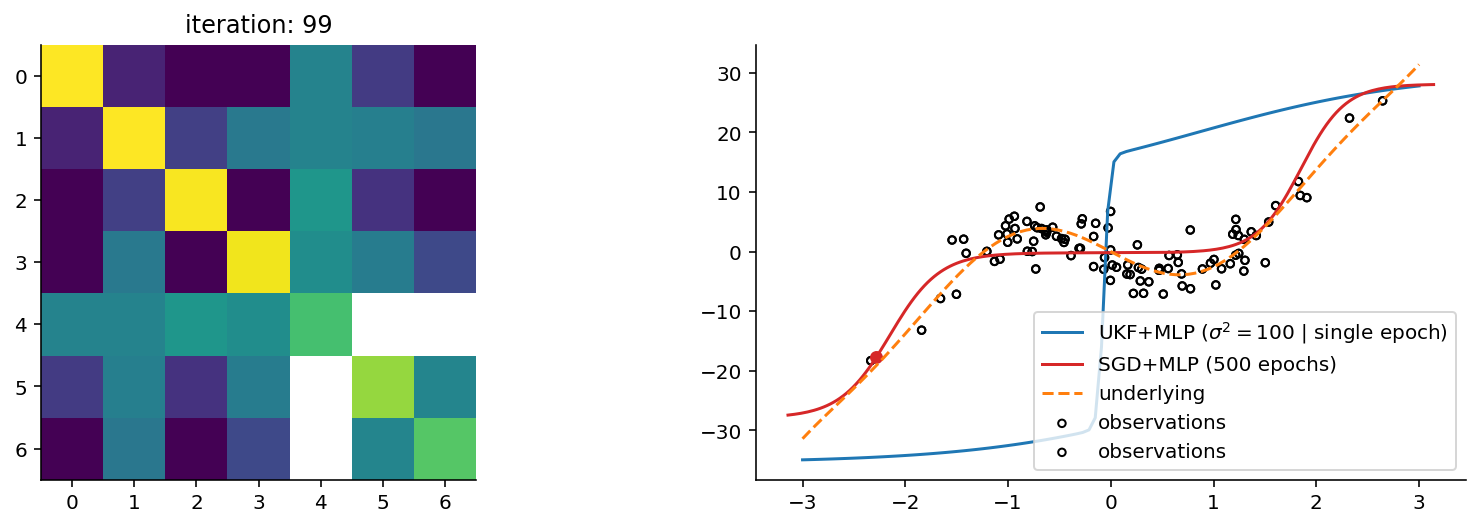

In [870]:
import matplotlib.animation as animation

nframes = 100
save_animation = True
fig, ax = plt.subplots(1,2, figsize=(14, 4))
def func(i):
    plt.cla()
    ax[0].set_title(f"iteration: {i}")
    ax[0].imshow(jnp.log(Sigma_hist[i]))
    ax[1].plot(x_range, fx_p(x_range, mu_hist[i, :, None]), label=f"UKF+MLP ($\sigma^2={σ ** 2}$ | single epoch)")
    ax[1].plot(xtest, yhat_test, c="tab:red", label=f"SGD+MLP ({n_epochs} epochs)")
    ax[1].plot(x_range, f(x_range), label="underlying", linestyle="--")
    ax[1].scatter(x, y, s=14, c="none", edgecolor="black", label="observations")
    ax[1].scatter(x, y, s=14, c="none", edgecolor="black", label="observations")
    ax[1].scatter(x[i], y[i], s=30, c="tab:red")
    ax[1].legend(loc="lower right")
    return ax
    
ani = animation.FuncAnimation(fig, func, frames=nframes)

#writer = animation.FFMpegFileWriter(bitrate=500)
if save_animation:    
    ani.save("/Users/gerardoduran/Desktop/cov_ukf3.gif", dpi=100, bitrate=-1)

In [931]:
def construct_params(params_flat, shapes, treedef):
    indices = jnp.array([np.prod(s) for s in shapes]).cumsum()
    split_reconstruction = jnp.array_split(params_flat, indices)
    split_reconstruction = [arr.reshape(shape) for arr, shape in zip(split_reconstruction, shapes)]
    params = jax.tree_unflatten(treedef, split_reconstruction)
    return params

In [932]:
ukf_params = construct_params(mu_hist[-1], shapes, treedef)

In [933]:
loss(ukf_params)

DeviceArray(67.17924, dtype=float32)

In [806]:
ukf = UnscentedKalmanFilter(fz, fx_vmap, Sigma_hist[-1,...], R, alpha, beta, kappa)
mu_hist, Sigma_hist = ukf.filter(mu_hist[-1, :], y[:, None], x)

In [649]:
def forward_mlp(X, params_flat, model, shapes, treedef):
    indices = jnp.array([np.prod(s) for s in shapes]).cumsum()
    split_reconstruction = jnp.array_split(params_flat, indices)
    split_reconstruction = [arr.reshape(shape) for arr, shape in zip(split_reconstruction, shapes)]
    params = jax.tree_unflatten(treedef, split_reconstruction)
    yhat = model.apply(params, X)
    return yhat

In [348]:
params_test = all_params * jnp.ones((1, 283))
fx_p(x[1, None], params_test[:, 1])

DeviceArray([[-25.98435]], dtype=float32)

In [350]:
params_test.shape

(22, 283)

In [349]:
fx_vmap = jax.vmap(fx_p, in_axes=[None, 1])
fx_vmap(x[1, None], params_test).shape

(283, 1, 1)

# EKF method

## Jacobian of the MLP

In [284]:
class D_MLP1D(nn.Module):
    n_hidden: int
        
    def setup(self):
        self.model = MLP1D(self.n_hidden)
    
    def __call__(self, x):
        return jax.jacfwd(self.model)(x)

In [295]:
X = normal(key2, (100, 2))

In [296]:
key = PRNGKey(314)
key1, key2 = split(key, 2)


n_hidden = 10
model = MLP1D(n_hidden)
D_model = MLP1D(n_hidden)

params = model.init(key1, X)
yhat = model.apply(params, X)

In [303]:
x.shape

(100,)

In [301]:
D_model.apply(params, X).shape

(100, 1, 1)

## References
* https://github.com/google/flax/issues/735
* https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html